# IMPORT

In [1]:
#!pip install pandas-profiling[notebook]
#!pip install optuna
#!pip install dostoevsky

In [2]:
#!pip install lightautoml -q

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, tqdm_notebook
from catboost import CatBoostRegressor, Pool
from catboost import cv

from sklearn.preprocessing import LabelEncoder

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 100)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

###
import datetime 
from pandas_profiling import ProfileReport # для EDA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format ='{:,.3f}'.format

import re
import json
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import optuna


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.3


# Functions

In [27]:
type(pd.Series(["0"])) == type(pd.Series([0]))

True

In [123]:
from scipy.stats.mstats import winsorize

In [239]:
df["modelDate"] = S.inverse_transform(np.array(df["modelDate"]).reshape(121540 ,1))

In [188]:
winsorize(np.array([10, 4, 9, 8, 5, np.nan, 7, 2, 1, 6]), limits=[0, None], nan_policy="omit").data

array([10.,  4.,  9.,  8.,  5., nan,  7.,  2.,  1.,  6.])

In [333]:
a = pd.Series([0,1,2,2,4,4,6], name="aaa")

In [301]:
a.loc[a.between(a.quantile(.1), a.quantile(0.8))==False] = None

In [306]:
5 in a.apply(lambda x:x*2).value_counts(dropna=False).reset_index()[:2]

False

In [329]:
a.apply(lambda x: x if x in a.value_counts(dropna=False).reset_index()[:3]["index"] else "Other")

0        0
1        1
2        2
3        2
4    Other
5    Other
6    Other
dtype: object

In [463]:
s = pd.Series([0,1,2,2,4,4,6])

In [342]:
dict_methods = dict({"std": StandardScaler,"minmax":MinMaxScaler, "label": LabelEncoder, None:1})

In [288]:
df = pd.DataFrame(np.array([[1.99999, 1], 
                            [2, 10], 
                            [3, 100], 
                            [4, 100]]),
                  columns=['a', 'b'])
df.loc[df["a"].between(df["a"].quantile(.1), df["a"].quantile(1))  == False, "a"] = None

In [497]:
class Prerocessor():
    """Улучшенный LabelEncoder"""
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from copy import deepcopy
    
    def __init__(self):
        self.dict_of_encoders = dict()
        self.cat_features = list()
        self.num_features = list()
        self.dict_methods = dict({"std": StandardScaler,"minmax":MinMaxScaler, "label": LabelEncoder, None:None})
        pass
    
    """
    Работа с любыми признаками
    """
    
    def fit_Encoder(self, method, Serie, column):
        E = self.dict_methods[method]()
        E.fit(Serie)
        self.dict_of_encoders[column] = E
    
    def fit(self, df:pd.DataFrame, features, method):
        """Обучение кодировщика"""
        if type(features) ==str:
            features = [features]
        for colum in features:
            self.fit_Encoder(method, df[colum], colum)
                
    def transform(self, df:pd.DataFrame, features):
        for colum in features:
            df[colum] = self.dict_of_encoders[colum].transform(df[colum])
        return df
    
    def fit_transform_Encoder(self, Serie, method, column):
        """Функция нижнего уровня, выполняет преобразование и записывает енкодер"""
        if method == None:
            return Serie
        if method not in dict_methods:
            Serie.map(method)
        if method != "label":
            Serie = np.array(Serie).reshape(len(Serie),1)
            
        E = self.dict_methods[method]()
        E.fit_transform(Serie)
        self.dict_of_encoders[column] = E
        return E.fit_transform(Serie)
    
    def fit_transform(self, df:pd.DataFrame, features, method, depth=None, 
                      q1=None, q2=None, cut_outliers=False, inplace=False):
        """Функция верхнего уровня, работает с датафреймом"""
        if type(features) ==str:
            features = [features]
        res = df.copy()
        for colum in features:                
            res[colum] = self.fit_transform_Serie(df[colum], method,depth, q1, q2, cut_outliers, colum)
            if inplace:
                df[colum] = res[colum]
        return res
    
        
    def fit_transform_Serie(self, Serie, method, depth=None, 
                            q1=None, q2=None, cut_outliers=False, name_of_feature = None):
        """Функция среднего уровня, работает с серией из датафрейма"""
        if depth:
            if 0<depth<1:
                VC = Serie.value_counts(dropna=False, normalize=True).reset_index()
                try:
                    VC = VC[VC[Serie.name] > depth]["index"]
                except:
                    VC = VC[VC[0] > depth]["index"]
                return self.fit_transform_Encoder(Serie.apply(lambda x: x if x in set(VC) else "N/A"),
                                    method,  name_of_feature)
            else:
                VC = Serie.value_counts(dropna=False).reset_index()[:int(depth)]["index"]
                return self.fit_transform_Encoder(Serie.apply(lambda x: x if x in set(VC) else "N/A"),
                                    method,  name_of_feature)
        if q1 or q2:
            if cut_outliers:
                Serie = self.outliers_mask(Serie, q1, q2)
            else:
                Serie = winsorize(Serie, limits=[q1, q2], nan_policy="omit").data
            return self.fit_transform_Encoder(Serie, method, name_of_feature)
        if cut_outliers:
            Serie = self.outliers_mask(Serie, 0.001, 0.999)
        #print(self.fit_transform_Encoder(method, Serie, name_of_feature))
        return self.fit_transform_Encoder(Serie, method, name_of_feature)
    
    def outliers_mask(self, Serie, q1, q2):
        if q1==None:
            q1=0
        if q2 == None:
            q2=1
        Serie.loc[Serie.between(Serie.quantile(q1), Serie.quantile(q2))==False] = None
        return Serie

    
    def inverse_transform(self, df:pd.DataFrame, columns=None):
        res = pd.DataFrame()
        
        if not columns:
            columns = df.columns
            
        if type(columns) == str:
            columns = list(columns)
        for col in columns:
            if col not in df.columns:
                print(col, " не найден")
                continue
            if col in self.dict_of_encoders.keys():
                try:
                    res[col] = self.dict_of_encoders[col].inverse_transform(df[col])
                except:
                    res[col] = self.dict_of_encoders[col].inverse_transform(np.array(df[col]).reshape(len(df[col]) ,1))
            else:
                res[col] = df[col]

        return res

    
    def inverse_transform_Serie(self, Serie, name_of_feature = None):
        if name_of_feature:
            res = self.dict_of_encoders[name_of_feature].inverse_transform(Serie)
        else:
            res = self.dict_of_encoders[Serie.name].inverse_transform(Serie)
        return res
    
#     def fit_transform_depth(self, df:pd.DataFrame, cat_features:list, depth):
#         self.cat_features = cat_features
#         for colum in cat_features:
#             VC = df[colum].value_counts(dropna=False).reset_index()[:depth]
#             LE = LabelEncoder()
#             df[colum] = df[colum].apply(lambda x: x if x in VC[colum] else "Other")
#             df[colum] = LE.fit_transform(df[colum])
#             self.dict_of_encoders[colum] = LE

            
            
            
            
            
            
    def transform_by_group(self, df:pd.DataFrame, group_features, agg_func, column, log, multiplier=1):
        """Функция для квантилизации"""
        GB = df.groupby(group_features)[column].agg(agg_func).reset_index()
        if log:
            GB[column] = np.log(GB[column]+1)
        GB[column+"_cut"] = pd.qcut(GB[column], q= int((GB[column].max() - GB[column].min())*multiplier))
        LE = LabelEncoder()
        GB[column+"_cut"] = LE.fit_transform(GB[column+"_cut"])
        self.dict_of_encoders[column+"_cut"]  = LE
        res = pd.merge(df, GB.drop(column, axis=1), on=group_features, how="left")
        return res
    
    def fillna_by_group(self, df, group_features, target_feature):
        """Справляется в случаях, когда более одной групповой переменной"""
        df.groupby(group_features, sort=False)[target_feature].apply(lambda x: x.fillna(x.median()))


    
    # Не моя функция, не проработана
    def undummify(df, prefix_sep="_"):
        cols2collapse = {
            item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
        }
        series_list = []
        for col, needs_to_collapse in cols2collapse.items():
            if needs_to_collapse:
                undummified = (
                    df.filter(like=col)
                    .idxmax(axis=1)
                    .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                    .rename(col)
                )
                series_list.append(undummified)
            else:
                series_list.append(df[col])
        undummified_df = pd.concat(series_list, axis=1)
        return undummified_df
    
        
    """
    Работа с численными признаками
    """

    ##винсоризация
    def robust_cut(s,a=0,b=1):
        return s.apply(lambda x:a if x<a else b if x>b else x)
    
    ##винсоризация по квантилям, но не предусмотрена отрезка выбросов в None
    def quant_cut(s, q1=0.01, q2=0.99):
        return robust_cut(s, s.quantile(q1), s.quantile(q2))

In [498]:
P = Prerocessor()

In [499]:
df = pd.read_pickle("data.pickle")

In [500]:
df[:5]

bodyType brand        color fuelType  modelDate  numberOfDoors  \
0            седан  AUDI       чёрный   бензин     30.000          4.000   
1            седан  AUDI      красный   бензин     38.000          4.000   
2  универсал 5 дв.  AUDI        синий   бензин     32.000          5.000   
3            седан  AUDI  серебристый   бензин     32.000          4.000   
4            седан  AUDI       чёрный   бензин     30.000          4.000   

   productionDate vehicleTransmission  engineDisplacement  enginePower  \
0              29        механическая               2.800      174.000   
1              34        механическая               1.800       90.000   
2              31        механическая               2.300      136.000   
3              31        механическая               1.800       90.000   
4              29        механическая               2.000      101.000   

                                         description  mileage    Привод  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000    полный   
1  Машина в оригинале не гнилая все вопросы по те...   173424  передний   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо рез...   230000    полный   
3                                                NaN   240000  передний   
4  Машина не гнилая, дыр нет, днище целое, даже в...   300000  передний   

    Руль  Владельцы       ПТС  Владение       price model_name  \
0  Левый      3.000  Оригинал       NaN 200,000.000        100   
1  Левый      3.000  Оригинал       NaN  60,000.000        100   
2  Левый      3.000  Оригинал       NaN  99,000.000        100   
3  Левый      3.000  Оригинал       NaN  65,000.000        100   
4  Левый      3.000  Дубликат       NaN 100,000.000        100   

   КомплектацияTrue country bodyTypeRough  sample  
0                 0  Europe         седан       1  
1                 0  Europe         седан       1  
2                 0  Europe     универсал       1  
3                 0  Europe         седан       1  
4                 0  Europe         седан       1

In [501]:
a = P.fit_transform(df, ["modelDate"],method='std', inplace=False)

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def ParseDateTest(x):
    if str(x) == "nan":
        return None
    x_spl = x.split()
    year = 0
    month = 0
    
    nums = []
    if re.findall(r"\d+", x):
        nums = re.findall(r"\d+", x)
        #print(nums)
    
    if  re.findall(r"год", x) or re.findall(r"лет", x):
        year = nums[0]
        #print(nums[0])
    if  re.findall(r"мес", x):
        month = nums[-1]
        #print(nums[-1])

    #for s in x_spl:
    #    if re.findall(r"\d", x):
    #        print(re.findall(r"\d", x))
        
    return datetime.timedelta(365 * int(year) + 30 * int(month))

def GetEngineDisplacement(x):
    row = str(x)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

def getbody(x, set_body:set):
    body = str(x).lower()
    if body in set_body:
        return body
    else:
        for b in set_body:
            if b in body:
                return b
    return body
    


# Прогнозирование стоимости автомобиля по характеристикам

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

# Setup

In [7]:
VERSION    = 16
DIR_TRAIN  = ""#'../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = ""#'../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# EDA

Начнём с ускоренного анализа при помощи Pandas Profiling

In [9]:
profile_train = ProfileReport(train, title="Pandas Profiling Report for train")
profile_test = ProfileReport(test, title="Pandas Profiling Report for test")

In [10]:
#profile_train.to_file("profile_train.html")
#profile_test.to_file("profile_test.html")

In [11]:
# Показать профайлинг внутри ноутбука
#profile_train
#profile_test

Чтобы не загромождать ноутбук, сохраним результаты профайлинга в HTML формате и откроем в браузере.

## Значения в колонках

In [12]:
for col in train.columns:
    display(train[col].value_counts(dropna=False).reset_index()[:10])

index  bodyType
0  Внедорожник 5 дв.     31885
1              Седан     30593
2      Хэтчбек 5 дв.      8668
3    Универсал 5 дв.      3385
4            Лифтбек      3121
5         Компактвэн      1922
6            Минивэн      1815
7      Хэтчбек 3 дв.      1377
8               Купе      1289
9         Седан Long      1104

index  brand
0    MERCEDES   8012
1         BMW   7393
2  VOLKSWAGEN   7139
3      NISSAN   5772
4     HYUNDAI   5734
5         KIA   5630
6      TOYOTA   4824
7        FORD   4797
8        AUDI   4084
9  MITSUBISHI   3933

index  color
0  040001  25212
1  FAFBFB  15824
2  CACECB  11336
3  97948F  10819
4  0000CC   8874
5  EE1D19   4508
6  200204   3583
7  007F00   2598
8  C49648   1854
9  22A0F8   1398

index  fuelType
0     бензин     75053
1     дизель     13907
2     гибрид       295
3    электро       111
4        газ        11
5  универсал         1

index  modelDate
0 2,006.000       6138
1 2,010.000       5905
2 2,009.000       5703
3 2,017.000       5636
4 2,018.000       5205
5 2,011.000       4758
6 2,005.000       4715
7 2,012.000       4507
8 2,007.000       4147
9 2,008.000       4072

index  name
0      2.0 AT (150 л.с.)  1610
1      1.6 AT (123 л.с.)  1386
2      1.6 AT (110 л.с.)  1200
3      1.6 MT (105 л.с.)   888
4       1.4 MT (75 л.с.)   783
5  2.0 AT (150 л.с.) 4WD   716
6      1.6 MT (109 л.с.)   714
7   1.7 MT (80 л.с.) 4WD   679
8      1.6 MT (110 л.с.)   677
9      1.6 AT (120 л.с.)   637

index  numberOfDoors
0  5.000          51625
1  4.000          33647
2  3.000           2211
3  2.000           1893
4    NaN              1
5  0.000              1

index  productionDate
0   2020           12524
1   2008            7043
2   2012            6630
3   2011            6192
4   2013            5601
5   2007            5428
6   2014            4555
7   2010            4474
8   2006            3622
9   2015            3145

index  vehicleConfiguration
0              SEDAN MECHANICAL 1.6                  4166
1               SEDAN AUTOMATIC 1.6                  3633
2      ALLROAD_5_DOORS VARIATOR 2.0                  3098
3     ALLROAD_5_DOORS AUTOMATIC 2.0                  2795
4               SEDAN AUTOMATIC 2.0                  2230
5   HATCHBACK_5_DOORS AUTOMATIC 1.6                  1820
6  HATCHBACK_5_DOORS MECHANICAL 1.6                  1510
7              SEDAN MECHANICAL 1.5                  1374
8              SEDAN MECHANICAL 1.8                  1243
9              SEDAN MECHANICAL 1.4                  1227

index  vehicleTransmission
0   AUTOMATIC                49218
1  MECHANICAL                25264
2       ROBOT                 7871
3    VARIATOR                 7024
4         NaN                    1

index  engineDisplacement
0   1.6               17032
1   2.0               13446
2   1.4                5649
3   1.8                5102
4   2.4                3272
5   2.5                2887
6   1.5                2145
7  2.0d                2092
8   200                1519
9   350                1506

index  enginePower
0 150.000         7058
1 249.000         3721
2 140.000         2898
3 105.000         2360
4 123.000         2302
5 110.000         2093
6 190.000         2087
7 115.000         1835
8 184.000         1638
9 109.000         1526

index  description
0                                                NaN         3254
1  РОЛЬФ Северо-Запад - это первый мегамолл автом...          246
2  ПРИГЛАШАЕМ на бесплатный тест-драйв!\nПРИ ПОКУ...          157
3  Автодилер года 2020\n\nПобедитель в номинации ...          131
4  УНИКАЛЬНОЕ ПРЕДЛОЖЕНИЕ НА  ВСЕ АВТОМОБИЛИ!!!  ...          114
5  Выгода до 82 000 руб. при обмене на Ваш автомо...          114
6  При покупке автомобиля до 15 сентября \n► Выго...          102
7  РОЛЬФ Северо-Запад - это первый мегамолл автом...           99
8  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...           97
9  РОЛЬФ - Официальный дилер и Лучший дилер Росси...           85

index  mileage
0       0    13588
1  200000     1136
2  150000     1048
3  180000      897
4  160000      860
5  170000      838
6  250000      834
7  120000      775
8  140000      741
9  130000      735

index  Комплектация
0                                        {'id': '0'}         59130
1  {'id': '21678548', 'name': 'Комфорт', 'availab...           257
2  {'id': '21397679', 'name': 'Intense+', 'availa...           224
3  {'id': '21426455', 'name': '450 4MATIC Sport P...           198
4  {'id': '21426444', 'name': '300 d 4MATIC Sport...           196
5  {'id': '22152659', 'name': 'Respect', 'availab...           191
6  {'id': '22174500', 'name': 'Inscription', 'ava...           162
7  {'id': '21436723', 'name': 'SE Top', 'availabl...           143
8  {'id': '21464201', 'name': 'E 200 Premium', 'a...           140
9  {'id': '21397672', 'name': 'Intense+', 'availa...           138

index  Привод
0  передний   47315
1    полный   35001
2    задний    7061
3       NaN       1

index   Руль
0   LEFT  87589
1  RIGHT   1789

index  Состояние
0    NaN      89378

index  Владельцы
0  3.000      36248
1  2.000      21006
2  1.000      18536
3    NaN      13588

index    ПТС
0   ORIGINAL  78597
1  DUPLICATE  10420
2        NaN    361

index  Таможня
0   True    89378

index  Владение
0                          NaN     60177
1  {'year': 2018, 'month': 10}       497
2   {'year': 2019, 'month': 8}       494
3   {'year': 2018, 'month': 8}       492
4   {'year': 2018, 'month': 9}       478
5  {'year': 2018, 'month': 11}       473
6  {'year': 2018, 'month': 12}       469
7   {'year': 2018, 'month': 5}       450
8   {'year': 2019, 'month': 9}       442
9   {'year': 2018, 'month': 6}       434

index  price
0 450,000.000   1212
1 350,000.000   1045
2 250,000.000    994
3 550,000.000    967
4 650,000.000    942
5 400,000.000    889
6 300,000.000    879
7 750,000.000    835
8 500,000.000    825
9 600,000.000    768

index  start_date
0  2020-09-01T10:01:11Z          93
1  2020-08-10T11:02:50Z          87
2  2020-08-21T14:41:04Z          78
3  2020-08-05T11:29:41Z          73
4  2020-08-21T14:41:13Z          71
5  2020-09-08T20:32:51Z          68
6  2020-09-04T10:24:58Z          65
7  2020-09-02T14:12:26Z          59
8  2020-09-04T11:21:47Z          59
9  2020-08-10T11:02:58Z          59

index  hidden
0    NaN   89378

index  model
0      FOCUS   2467
1    SOLARIS   1769
2        5ER   1675
3      ASTRA   1548
4    OCTAVIA   1497
5        RIO   1469
6   E_KLASSE   1432
7        3ER   1419
8     PASSAT   1399
9  OUTLANDER   1369

In [13]:
for col in test.columns:
    display(test[col].value_counts(dropna=False).reset_index()[:10])

index  bodyType
0                 седан     13147
1     внедорожник 5 дв.     12228
2               лифтбек      2232
3         хэтчбек 5 дв.      2124
4       универсал 5 дв.      1276
5               минивэн       995
6                  купе       824
7            компактвэн       489
8         хэтчбек 3 дв.       485
9  пикап двойная кабина       280

index  brand
0         BMW   4473
1  VOLKSWAGEN   4404
2      NISSAN   4393
3    MERCEDES   4180
4      TOYOTA   3913
5        AUDI   3421
6  MITSUBISHI   2843
7       SKODA   2741
8       VOLVO   1463
9       HONDA   1150

index  car_url
0  https://auto.ru/cars/used/sale/skoda/octavia/1...        1
1  https://auto.ru/cars/used/sale/lexus/lx/109965...        1
2  https://auto.ru/cars/used/sale/lexus/lx/109632...        1
3  https://auto.ru/cars/used/sale/lexus/rx/110124...        1
4  https://auto.ru/cars/used/sale/lexus/rx/109267...        1
5  https://auto.ru/cars/used/sale/lexus/rx/109760...        1
6  https://auto.ru/cars/used/sale/lexus/lx/110115...        1
7  https://auto.ru/cars/used/sale/lexus/ls/109131...        1
8  https://auto.ru/cars/used/sale/lexus/rx/109714...        1
9  https://auto.ru/cars/used/sale/lexus/rx/109688...        1

index  color
0       чёрный  11010
1        белый   6133
2  серебристый   4113
3        серый   3984
4        синий   3289
5      красный   1531
6   коричневый   1501
7      зелёный    952
8      бежевый    639
9      голубой    457

index  complectation_dict
0                                                NaN               28268
1  {"id":"4562904","name":"Elegance","available_o...                  51
2  {"id":"20913628","name":"Style","available_opt...                  26
3  {"id":"7768581","name":"Ambition","available_o...                  25
4  {"id":"7150237","name":"Highline","available_o...                  24
5  {"id":"7953884","name":"Люкс 7 мест","availabl...                  22
6  {"id":"6129708","name":"SE","available_options...                  22
7  {"id":"4562901","name":"Ambition","available_o...                  21
8  {"id":"2430584","name":"Murano","available_opt...                  21
9  {"id":"2324184","name":"Стандарт","available_o...                  21

index  description
0  Выгода до 82 000 руб. при обмене на Ваш автомо...          264
1  РОЛЬФ - Официальный дилер и Лучший дилер Росси...          259
2  Автодилер года 2020\n\nПобедитель в номинации ...          211
3  • Автомобиль проверен по 110 пунктам\n• Автокр...          161
4  Купить автомобиль с пробегом в РОЛЬФ — это быс...          153
5  РОЛЬФ Премиум – крупнейший официальный дилер М...          148
6  При покупке автомобиля:\n► Возможна покупка ав...          124
7  Выгода от 30 000 руб. при обмене на Ваш автомо...          106
8  РОЛЬФ Северо-Запад - это первый мегамолл автом...          100
9  Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...           80

index  engineDisplacement
0  2.0 LTR                7391
1  1.6 LTR                4973
2  3.0 LTR                3915
3  1.8 LTR                3349
4  2.5 LTR                2477
5  2.4 LTR                1745
6  3.5 LTR                1710
7  1.4 LTR                1635
8  1.5 LTR                 725
9  1.2 LTR                 485

index  enginePower
0  249 N12         1708
1  150 N12         1699
2  110 N12         1039
3  170 N12          977
4  105 N12          955
5  140 N12          942
6  184 N12          923
7  152 N12          873
8  102 N12          832
9  190 N12          779

index  equipment_dict
0                                                NaN            9996
1                                   {"leather":true}             108
2                                       {"gbo":true}             106
3                              {"fabric-seats":true}              59
4                                {"roof-rails":true}              37
5  {"cruise-control":true,"esp":true,"airbag-driv...              21
6                                     {"hatch":true}              20
7                            {"combo-interior":true}              15
8                                      {"lock":true}              15
9              {"roof-rails":true,"12v-socket":true}              13

index  fuelType
0   бензин     28601
1   дизель      5800
2   гибрид       223
3  электро        55
4      газ         7

index  image
0  https://avatars.mds.yandex.net/get-verba/21620...     13
1  https://avatars.mds.yandex.net/get-verba/21620...      9
2  https://avatars.mds.yandex.net/get-verba/78701...      8
3  https://avatars.mds.yandex.net/get-verba/10303...      8
4  https://avatars.mds.yandex.net/get-verba/78701...      7
5  https://avatars.mds.yandex.net/get-verba/21620...      7
6  https://avatars.mds.yandex.net/get-verba/78701...      6
7  https://avatars.mds.yandex.net/get-verba/21620...      6
8  https://avatars.mds.yandex.net/get-verba/21620...      5
9  https://avatars.mds.yandex.net/get-verba/10303...      5

index  mileage
0  200000      436
1  150000      382
2  300000      381
3  180000      347
4  250000      346
5  160000      343
6  170000      297
7  140000      259
8  130000      256
9  190000      252

index  modelDate
0   2010       2503
1   2013       2275
2   2008       2243
3   2011       2173
4   2006       2169
5   2009       2098
6   2012       2047
7   2014       1918
8   2005       1805
9   2007       1733

index  model_info
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...        1404
1  {"code":"LANCER","name":"Lancer","ru_name":"Ла...         843
2  {"code":"PASSAT","name":"Passat","ru_name":"Па...         776
3  {"code":"A6","name":"A6","ru_name":"А6","morph...         757
4  {"code":"POLO","name":"Polo","ru_name":"Поло",...         724
5  {"code":"CAMRY","name":"Camry","ru_name":"Камр...         706
6  {"code":"X_TRAIL","name":"X-Trail","ru_name":"...         654
7  {"code":"A4","name":"A4","ru_name":"А4","morph...         626
8  {"code":"QASHQAI","name":"Qashqai","ru_name":"...         609
9  {"code":"OUTLANDER","name":"Outlander","ru_nam...         544

index  model_name
0   OCTAVIA        1418
1       5ER        1026
2    LANCER         855
3  E_KLASSE         809
4    PASSAT         782
5        A6         757
6       3ER         752
7      POLO         724
8     CAMRY         709
9        X5         675

index  name
0       1.6 AT (110 л.с.)   631
1       1.6 MT (102 л.с.)   410
2       1.6 MT (110 л.с.)   314
3  2.0 CVT (141 л.с.) 4WD   309
4      1.4 AMT (122 л.с.)   308
5      1.4 AMT (150 л.с.)   299
6       1.6 MT (105 л.с.)   293
7       2.5 AT (181 л.с.)   278
8      1.8 AMT (152 л.с.)   278
9        1.6 MT (98 л.с.)   265

index  numberOfDoors
0      5          18703
1      4          14126
2      2           1206
3      3            650
4      0              1

index  parsing_unixtime
0  1603226273                 1
1  1603301936                 1
2  1603301988                 1
3  1603301984                 1
4  1603301980                 1
5  1603301977                 1
6  1603301973                 1
7  1603301970                 1
8  1603301966                 1
9  1603301962                 1

index  priceCurrency
0   RUB          34686

index  productionDate
0   2012            2798
1   2008            2606
2   2011            2589
3   2013            2488
4   2014            2134
5   2007            1964
6   2010            1826
7   2015            1770
8   2017            1667
9   2016            1615

index  sell_id
0  1100575026        1
1  1099652342        1
2  1096320100        1
3  1101246116        1
4  1092674980        1
5  1097603312        1
6  1101152502        1
7  1091314224        1
8  1097141728        1
9  1096884322        1

index  super_gen
0  {"id":"6214876","displacement":1598,"engine_ty...        193
1  {"id":"20726520","displacement":1598,"engine_t...        159
2  {"id":"4561004","displacement":1798,"engine_ty...        148
3  {"id":"7277667","displacement":1598,"engine_ty...        139
4  {"id":"2404949","displacement":1596,"engine_ty...        131
5  {"id":"9279339","displacement":1598,"engine_ty...        120
6  {"id":"6214877","displacement":1598,"engine_ty...        119
7  {"id":"7024189","displacement":1997,"engine_ty...        116
8  {"id":"20494479","displacement":1584,"engine_t...        115
9  {"id":"7150232","displacement":1798,"engine_ty...        112

index  vehicleConfiguration
0  ALLROAD_5_DOORS AUTOMATIC 3.0                  2389
1            SEDAN AUTOMATIC 2.0                  1610
2  ALLROAD_5_DOORS AUTOMATIC 2.0                  1327
3   ALLROAD_5_DOORS VARIATOR 2.0                  1323
4           SEDAN MECHANICAL 1.6                  1314
5            SEDAN AUTOMATIC 1.6                  1037
6            SEDAN AUTOMATIC 2.5                   937
7            SEDAN AUTOMATIC 3.0                   927
8  ALLROAD_5_DOORS AUTOMATIC 3.5                   678
9            SEDAN AUTOMATIC 2.4                   669

index  vehicleTransmission
0    автоматическая                19596
1      механическая                 7209
2          вариатор                 3999
3  роботизированная                 3882

index  vendor
0  EUROPEAN   20682
1  JAPANESE   14004

index  Владельцы
0  3 или более      15957
1   1 владелец       9459
2  2 владельца       9270

index  Владение
0                 NaN     22691
1  1 год и 10 месяцев       209
2              2 года       197
3               1 год       194
4     1 год и 1 месяц       193
5    1 год и 2 месяца       187
6    2 года и 1 месяц       182
7  1 год и 11 месяцев       179
8   1 год и 6 месяцев       171
9    1 год и 4 месяца       169

index    ПТС
0  Оригинал  30098
1  Дубликат   4587
2       NaN      1

index  Привод
0  передний   15565
1    полный   15020
2    задний    4101

index   Руль
0   Левый  33287
1  Правый   1399

index  Состояние
0  Не требует ремонта      34686

index  Таможня
0  Растаможен    34686

## Совместная обработка Train и Test

- Списки колонок

In [14]:
print()
print(test.columns)


Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')


Идём во вкладку Alerts в Pandas Profiling и делаем следующие выводы:
- Признак "Таможня" следует исключить, так как имеет только 1 значение

In [15]:
train.drop("Таможня", axis=1, inplace=True)
test.drop("Таможня", axis=1, inplace=True)

- Признаки Состояние и priceCurrency в тестовом датасете также имеют только 1 значение и подлежат удалению

In [16]:
test.drop(["priceCurrency", "Состояние"], axis=1, inplace=True)

- Тренировочный Датасет содержит большое количество дубликатов

In [17]:
print(len(train))
train.drop_duplicates(inplace=True)
print(len(train))

89378
87264


- Работа с пропусками

В обучающей выборке:

In [18]:
(train.isnull().sum()[train.isnull().sum() != 0] / len(train)).sort_values(ascending=False)

Состояние              1.000
hidden                 1.000
Владение               0.668
Владельцы              0.138
description            0.037
price                  0.005
ПТС                    0.004
bodyType               0.000
modelDate              0.000
name                   0.000
numberOfDoors          0.000
vehicleConfiguration   0.000
vehicleTransmission    0.000
engineDisplacement     0.000
enginePower            0.000
Привод                 0.000
dtype: float64

- Нельзя обучать на пустом целевом признаке

In [19]:
print(train["price"].isnull().sum())
train = train[train['price'].notna()]

410


- Удалим колонки "Состояние" и "hidden"

In [20]:
train.drop(["Состояние", "hidden"], axis=1, inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


В тестовой выборке

In [21]:
(test.isnull().sum()[test.isnull().sum() != 0] / len(test)).sort_values(ascending=False)

complectation_dict   0.815
Владение             0.654
equipment_dict       0.288
ПТС                  0.000
dtype: float64

- Комплектация имеет много одинаковых значений, а complectation_dict имеет много пропусков. Используем заполняемость как фактор:

In [22]:
train["КомплектацияTrue"] = (train["Комплектация"] != "{'id': '0'}").astype(int)
test["КомплектацияTrue"] = test["complectation_dict"].map(pd.isna)

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/2691694745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["КомплектацияTrue"] = (train["Комплектация"] != "{'id': '0'}").astype(int)


В целом можно заняться распознаванием комплектаций и выделять наиболее значимые слова, но сэкономим время

In [23]:
train.drop(['Комплектация'], axis=1, inplace=True)
test.drop(['complectation_dict'], axis=1, inplace=True)

- vehicleConfiguration не несёт дополнительной информации, так как уже разбит на **bodyType**, **vehicleTransmission**, **engineDisplacement**, его можно удалить

In [24]:
train.drop(["vehicleConfiguration"], axis=1, inplace=True)
test.drop(["vehicleConfiguration"], axis=1, inplace=True)

- Данные в sell_id являются уникальными номерами и подлежат удалению

[      2665   33504008   40521560 ... 1101373573 1101373897 1101374610]


<AxesSubplot:>

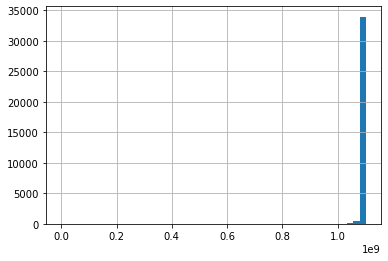

In [25]:
print(np.sort(test["sell_id"].unique()))
test["sell_id"].hist(bins=50)

In [26]:
test.drop(["sell_id"], axis=1, inplace=True)

- car_url содержит ссылку на авто из тестовой выборки. Мог бы быть полезен для парсинга дополнительных признаков, но я не придумал, что оттуда можно ещё вытащить, кроме комплектации, которая итак представлена в словаре.

In [27]:
test.drop(["car_url"], axis=1, inplace=True)

- equipment_dict используется только в test и не может быть использован для обучения и прогноза стоимости

In [28]:
test.drop(["equipment_dict"], axis=1, inplace=True)

- image содержит ссылки на картинки и используется только в test, а значит бесполезен

In [29]:
test.drop(["image"], axis=1, inplace=True)

- super_gen содержит описание двигателя и используется только в test

In [30]:
test.drop(["super_gen"], axis=1, inplace=True)

- model_info содержится только в test и уже разобран на дополнительные признаки

In [31]:
test.drop(["model_info"], axis=1, inplace=True)

- Используем время парсинга для работы с временными признаками в test

In [32]:
parsing_time = datetime.datetime.fromtimestamp(test["parsing_unixtime"].mean())
parsing_time
test.drop("parsing_unixtime", axis=1, inplace=True)

In [33]:
train["Владение"] = parsing_time - pd.to_datetime(train["Владение"].progress_apply(lambda x: "" if (pd.isnull(x) or str(x) == 'nan') else
                 datetime.date(eval(str(x))['year'], eval(str(x))['month'],1)))
test["Владение"] = test["Владение"].apply(ParseDateTest)

train["Владение"] = train["Владение"].dt.days
test["Владение"] = test["Владение"].dt.days

train['modelDate'] = 2020 - train['modelDate']
test['modelDate'] = 2020 - test['modelDate']
train['productionDate'] = 2020 - train['productionDate']
test['productionDate'] = 2020 - test['productionDate']

  0%|          | 0/86854 [00:00<?, ?it/s]

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/3678694702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Владение"] = parsing_time - pd.to_datetime(train["Владение"].progress_apply(lambda x: "" if (pd.isnull(x) or str(x) == 'nan') else
C:\Users\Max\AppData\Local\Temp/ipykernel_12244/3678694702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Владение"] = train["Владение"].dt.days
C:\Users\Max\AppData\Local\Temp/ipykernel_12244/3678694702.py:8: SettingWithCopyWarning: 
A value is tryin

- start_date непонятный признак, который используется только в train

<AxesSubplot:>

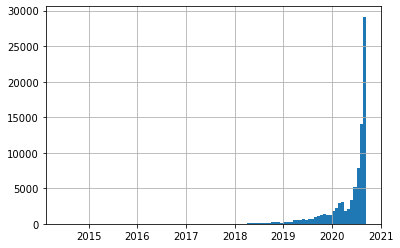

In [34]:
pd.to_datetime(train["start_date"]).hist(bins=100)

In [35]:
train.drop("start_date", axis=1, inplace=True)

- vendor есть только в тестовой выборке, используем словарь для получения конкретной страны бренда

In [36]:
test.groupby(["vendor", "brand"])["brand"].count()

vendor    brand     
EUROPEAN  AUDI          3421
          BMW           4473
          MERCEDES      4180
          SKODA         2741
          VOLKSWAGEN    4404
          VOLVO         1463
JAPANESE  HONDA         1150
          INFINITI       871
          LEXUS          834
          MITSUBISHI    2843
          NISSAN        4393
          TOYOTA        3913
Name: brand, dtype: int64

In [37]:
test.drop("vendor", axis=1, inplace=True)

In [38]:
dict_countries = {'Europe': ['AUDI','BMW','OPEL','PORSCHE','VOLKSWAGEN','MERCEDES', "SKODA", "VOLVO", "CITROEN", "PEUGEOT", "RENAULT"],
                  'Japan':   ['HONDA','INFINITI','LEXUS','MAZDA','MITSUBISHI','NISSAN','SUBARU','SUZUKI','TOYOTA'],
                  'USA':     ['CADILLAC','CHEVROLET','CHRYSLER','DODGE','FORD','JEEP'],
                  'China':   ['CHERY','GEELY','GREAT_WALL'],
                  'UK':      ['JAGUAR','MINI','LAND_ROVER'],
                  'Korea':   ['DAEWOO','HYUNDAI','KIA','SSANG_YONG']}
inv_dict_countries = dict()
for key in dict_countries.keys():
    for value in dict_countries[key]:
        inv_dict_countries[value] = key

In [39]:
train["country"] = train["brand"].apply(lambda x: inv_dict_countries[x])
test["country"] = test["brand"].apply(lambda x: inv_dict_countries[x])

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/4238479035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["country"] = train["brand"].apply(lambda x: inv_dict_countries[x])


- Признак name разобран на составляющие, можем от него избавиться:

In [40]:
train.drop("name", axis=1, inplace=True)
test.drop("name", axis=1, inplace=True)

- Признак Владельцы:

In [41]:
train[train["Владельцы"].isna()]["productionDate"].value_counts()

0    10854
1     1061
2       82
3        1
Name: productionDate, dtype: int64

In [42]:
# чаще всего машина новая, но поскольку в тестовой выборке представлены только 1+ владельцы, лучше присвоим пропускам значение 1, как наименьшее
train["Владельцы"] = train["Владельцы"].fillna(1)
test["Владельцы"] = test["Владельцы"].apply(lambda x: x[0]).astype(int)

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/2958620958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Владельцы"] = train["Владельцы"].fillna(1)


- некоторые признаки требуют предобработки, используем словари:

In [43]:
dict_trans = {"MECHANICAL": "механическая", "AUTOMATIC": "автоматическая", "ROBOT": "роботизированная", "VARIATOR": "вариатор"}
dict_PTS = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
dict_Руль = {'LEFT': 'Левый', 'RIGHT': 'Правый'}
# В обучающей выборке цвета представлены в виде кодов, приведем их к единому виду:
dict_color = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB': 'серебристый', '97948F': 'серый', '0000CC': 'синий','EE1D19': 'красный', '200204': 'коричневый',
                '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

In [44]:
# Приведём названия к единому виду
train.rename({"model":"model_name"}, axis=1, inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [45]:
# приведём кузова к единому виду (особенно это каксалось пикапов)
set_body = set(test["bodyType"].unique())
train["bodyType"] = train["bodyType"].apply(lambda x: getbody(x, set_body))
train["bodyTypeRough"] = train["bodyType"].apply(lambda x: str(x).lower().split()[0])
test["bodyTypeRough"] = test["bodyType"].apply(lambda x: str(x).lower().split()[0])

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/459099897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bodyType"] = train["bodyType"].apply(lambda x: getbody(x, set_body))
C:\Users\Max\AppData\Local\Temp/ipykernel_12244/459099897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["bodyTypeRough"] = train["bodyType"].apply(lambda x: str(x).lower().split()[0])


In [46]:
# приведём трансмиссию к виду в test
train["vehicleTransmission"] = train["vehicleTransmission"].apply(lambda x: "автоматическая" if pd.isnull(x) else dict_trans[x])

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/1282894528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["vehicleTransmission"] = train["vehicleTransmission"].apply(lambda x: "автоматическая" if pd.isnull(x) else dict_trans[x])


In [47]:
# приведём ПТС к виду в test
train["ПТС"] = train["ПТС"].apply(lambda x: 'Оригинал' if pd.isnull(x) else dict_PTS[x])

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/1887892374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["ПТС"] = train["ПТС"].apply(lambda x: None if pd.isnull(x) else dict_PTS[x])


In [48]:
# Распознаём объём двигателя через регулярные выражения
train["engineDisplacement"] = train["engineDisplacement"].apply(GetEngineDisplacement)
test["engineDisplacement"] = test["engineDisplacement"].apply(GetEngineDisplacement)

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/1562008742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["engineDisplacement"] = train["engineDisplacement"].apply(GetEngineDisplacement)


In [49]:
# Приводим мощность к целым значениям
train["enginePower"] = train["enginePower"].apply(lambda x: (int)(x) if pd.isnull(x) != True else None)
test["enginePower"] = test["enginePower"].apply(lambda x : (int)(x.split(' ')[0]))

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/2587770394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["enginePower"] = train["enginePower"].apply(lambda x: (int)(x) if pd.isnull(x) != True else None)


In [50]:
# приведём Руль и color к виду в test
train["Руль"].replace(dict_Руль, inplace=True)
train['color'].replace(dict_color, inplace=True)

C:\Users\Max\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [51]:
train[:1]

bodyType brand   color fuelType  modelDate  numberOfDoors  productionDate  \
0    седан  AUDI  чёрный   бензин     30.000          4.000              29   

  vehicleTransmission  engineDisplacement  enginePower  \
0        механическая               2.800      174.000   

                                         description  mileage  Привод   Руль  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  полный  Левый   

   Владельцы       ПТС  Владение       price model_name  КомплектацияTrue  \
0      3.000  Оригинал       NaN 200,000.000        100                 0   

  country bodyTypeRough  
0  Europe         седан

In [52]:
test[:1]

bodyType  brand  color                                        description  \
0  лифтбек  SKODA  синий  Все автомобили, представленные в продаже, прох...   

   engineDisplacement  enginePower fuelType  mileage  modelDate model_name  \
0               1.200          105   бензин    74000          7    OCTAVIA   

   numberOfDoors  productionDate vehicleTransmission  Владельцы  Владение  \
0              5               6    роботизированная          3       NaN   

        ПТС    Привод   Руль  КомплектацияTrue country bodyTypeRough  
0  Оригинал  передний  Левый              True  Europe       лифтбек

## Создаём pickle перед работой с description

In [53]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = train.append(test, sort=False).reset_index(drop=True) # объединяем

C:\Users\Max\AppData\Local\Temp/ipykernel_12244/545692207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sample'] = 1 # помечаем где у нас трейн


In [54]:
data.shape

(121540, 23)

In [55]:
data.to_pickle("data.pickle")

# Работа с description

In [56]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
data["descriptionTrue"] = data["description"].apply(lambda x: str.join(" ", re.findall(r"\w+", re.sub("[^\D]", " ", str(x)))).lower())

In [58]:
data["dealer"] = data["descriptionTrue"].apply(lambda x: ("услов" in x) or ("выгод" in x) or (" центр " in x) or ("обраща" in x) or ("взнос" in x)).astype(int)

In [59]:
#!pip install pymorphy2
#!pip install -U gensim
#nltk.download('punkt')
import pymorphy2


In [60]:
class Porter:
	PERFECTIVEGROUND =  re.compile(u"((ив|ивши|ившись|ыв|ывши|ывшись)|((?<=[ая])(в|вши|вшись)))$")
	REFLEXIVE = re.compile(u"(с[яь])$")
	ADJECTIVE = re.compile(u"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|ую|юю|ая|яя|ою|ею)$")
	PARTICIPLE = re.compile(u"((ивш|ывш|ующ)|((?<=[ая])(ем|нн|вш|ющ|щ)))$")
	VERB = re.compile(u"((ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю)|((?<=[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|нно)))$")
	NOUN = re.compile(u"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
	RVRE = re.compile(u"^(.*?[аеиоуыэюя])(.*)$")
	DERIVATIONAL = re.compile(u".*[^аеиоуыэюя]+[аеиоуыэюя].*ость?$")
	DER = re.compile(u"ость?$")
	SUPERLATIVE = re.compile(u"(ейше|ейш)$")
	I = re.compile(u"и$")
	P = re.compile(u"ь$")
	NN = re.compile(u"нн$")

	def stem(word):
		word = word.lower()
		word = word.replace(u'ё', u'е')
		m = re.match(Porter.RVRE, word)
		if m and m.groups():
			pre = m.group(1)
			rv = m.group(2)
			temp = Porter.PERFECTIVEGROUND.sub('', rv, 1)
			if temp == rv:
				rv = Porter.REFLEXIVE.sub('', rv, 1)
				temp = Porter.ADJECTIVE.sub('', rv, 1)
				if temp != rv:
					rv = temp
					rv = Porter.PARTICIPLE.sub('', rv, 1)
				else:
					temp = Porter.VERB.sub('', rv, 1)
					if temp == rv:
						rv = Porter.NOUN.sub('', rv, 1)
					else:
						rv = temp
			else:
				rv = temp
			
			rv = Porter.I.sub('', rv, 1)

			if re.match(Porter.DERIVATIONAL, rv):
				rv = Porter.DER.sub('', rv, 1)

			temp = Porter.P.sub('', rv, 1)
			if temp == rv:
				rv = Porter.SUPERLATIVE.sub('', rv, 1)
				rv = Porter.NN.sub(u'н', rv, 1)
			else:
				rv = temp
			word = pre+rv
		return word
	stem=staticmethod(stem)



In [61]:
from nltk.stem.porter import PorterStemmer


morph = pymorphy2.MorphAnalyzer()
def clean_review(review):
    """
    Receives a raw review and clean it using the following steps:
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming

    Args:
        review: the review that iwill be cleaned
    Returns:
        a clean review using the mentioned steps above.
    """
    s = set(stopwords.words("russian"))
    s.remove("не")
    s.remove("нет")

    review = str.join(" ", re.findall(r"\w+", re.sub("[^\D]", " ", str(review)))).lower()
    review = nltk.word_tokenize(review)
    # избавляемся от стоп-слов
    #stemmer = PorterStemmer()
    stemmer = Porter()
    #review = [stemmer.stem(word) for word in review if word not in s]
    review = [stemmer.stem(word) for word in review if word not in s]
    # слова к нормальной форме
    #morph = pymorphy2.MorphAnalyzer()
    res = list()
    for word in review:
        res.append(morph.parse(word)[0].normal_form)
    return res#" ".join(review)

[Dostoevsky — анализ тональности в Python за 5 минут](https://github.com/bureaucratic-labs/dostoevsky)

In [62]:
#!python -m dostoevsky download fasttext-social-network-model # это набор аннотированных данных собранный из социальной сети ВКонтакте
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [63]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

messages =  data["description"].astype(str).values
results = model.predict(messages, k=5)

In [64]:
res_df = pd.DataFrame(results)
data["description_neutral"] = res_df["neutral"]
data["description_negative"] = res_df["negative"]
data["description_skip"] = res_df["skip"]
data["description_positive"] = res_df["positive"]
data["description_speech"] = res_df["speech"]

In [65]:
print(data[data["dealer"] == 1]["description_positive"].mean())
print(data[data["dealer"] == 0]["description_positive"].mean())

0.05734825881679042
0.08912024468864108


Как мы видим, средняя оценка тональности отзывов собственников выше

In [66]:
# Подготовим данные для векторизации
data["descriptionTrue"] = data["description"].progress_apply(lambda x: clean_review(str(x)))

  0%|          | 0/121540 [00:00<?, ?it/s]

Запишем данные после долгой обработки

In [67]:
data.to_pickle("data_1.pickle")

In [68]:
data = pd.read_pickle("data_1.pickle")

In [69]:
desc_list = data["descriptionTrue"].tolist()

In [70]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(desc_list, min_count=20, vector_size=50)

In [71]:
# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in tqdm(desc_list):
    X.append(doc_vectorizer(doc, model))

  0%|          | 0/121540 [00:00<?, ?it/s]

In [72]:
data["description_vectorized"] = X

In [73]:
data["description"]

0          Машина  в приличном состоянии ,не гнилая не р...
1         Машина в оригинале не гнилая все вопросы по те...
2         ПТС Оригинал!\nПолный комплект ключей!\nПо рез...
3                                                       NaN
4         Машина не гнилая, дыр нет, днище целое, даже в...
                                ...                        
121535    Продается BMW 316i в отличном состоянии. Прода...
121536                       Продаётся отличный автомобиль.
121537                                    Хорошее состояние
121538    Автомобиль в идеальном состоянии . Куплен новы...
121539     Пробег реальный, состояние отличное! Авторска...
Name: description, Length: 121540, dtype: object

In [74]:
data["description_vectorized"] =data["description_vectorized"].progress_apply(lambda x: None if x.shape == (0,) else x)

  0%|          | 0/121540 [00:00<?, ?it/s]

In [75]:
np.asarray((data["description_vectorized"][data["description_vectorized"].isnull() == False].values).tolist()).shape

(121455, 50)

In [76]:
_X = np.asarray((data["description_vectorized"][data["description_vectorized"].isnull() == False].values).tolist())

In [77]:
for doc in X:
    if doc.shape == (0,):
        continue
    if doc.shape != (50,1):
        doc = doc.reshape(50,1)

In [78]:
np.array(data["description_vectorized"]).shape

(121540,)

In [79]:
from sklearn.decomposition import PCA

In [80]:
pca = PCA(n_components=2)
_X = pca.fit_transform(_X)

In [81]:
# t-SNE – метод понижения размерности
#from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
#tsne = TSNE(n_components=2, random_state=0, ini)

# Преобразуем наши данные, понизив размерность с 50 до 2
#_X = tsne.fit_transform(_X)

print(_X.shape)

(121455, 2)


Кластеризация

In [82]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=3)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(_X)

KMeans(n_clusters=3)

In [83]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[-2.2246397  -1.1149735 ]
 [ 6.9657574  -0.32682174]
 [-0.18454432  7.008927  ]]


In [84]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(_X, y_pred, metric='euclidean'))

Коэффициент силуэта: 0.580


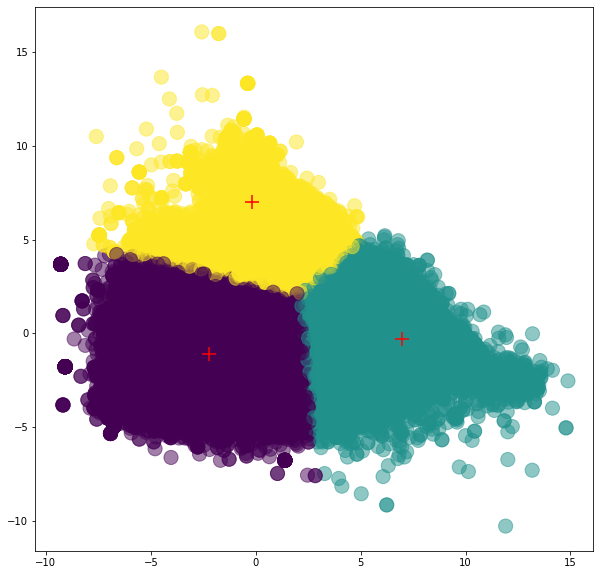

In [85]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(_X[:, 0], _X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

In [86]:
data.loc[data["description_vectorized"].isnull() == False, "description_claster"] = y_pred

In [89]:
data.to_pickle("data_2.pickle")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(3, 3))
X2 = vectorizer2.fit_transform(train["descriptionTrue"])
vectorizer2.get_feature_names_out()

# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n\n')

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train["description"])
vectorizer.get_feature_names_out()


array(['00 00 00', '00 00 02', '00 00 без', ..., '𝐁𝐞𝐧𝐳 𝐂𝟏𝟖𝟎 пробег',
       '𝐂𝟏𝟖𝟎 пробег 2730', '𝐌𝐞𝐫𝐜𝐞𝐝𝐞𝐬 𝐁𝐞𝐧𝐳 𝐂𝟏𝟖𝟎'], dtype=object)

In [ ]:
dict_words = dict()
L = []

for item in data["description"]:
    if pd.isna(item):
        L.append(None)
        continue
    item = item.upper().replace(",", "").replace(".", " ").replace("  "," ").strip()
    str_list= re.split(";|,|\s|\n|/", item)
    if len(str_list)>0:
        while "" in str_list:
            str_list.remove('')
        L.append(str_list)
        for i in str_list:
            if i in dict_words.keys():
                dict_words[i] +=1
            else:
                dict_words[i] = 1
dict_words

sorted_tuple = sorted(dict_words.items(), key =lambda x: x[1], reverse=True)
sorted_tuple
dict_words = dict(sorted_tuple)

In [ ]:
def Score(list_words):
    score = 0
    for i in list_words:
        if i !="":
            if i in dict_words.keys():
                score += dict_words[i]
            else:
                pass
    return score/len(list_words)

In [ ]:
data["descriptionTrue2"] = data["description"].progress_apply(lambda x: x.upper().replace(",", "").replace(".", " ").replace("  "," ").strip() if pd.isna(x) ==False else " ")
data["descriptionLen"] = data["descriptionTrue2"].progress_apply(lambda item: len(re.split(";|,|\s|\n|/", item)))

  0%|          | 0/121950 [00:00<?, ?it/s]

  0%|          | 0/121950 [00:00<?, ?it/s]

In [ ]:
data["descriptionLenLog"] = np.log(data["descriptionLen"] + 1)

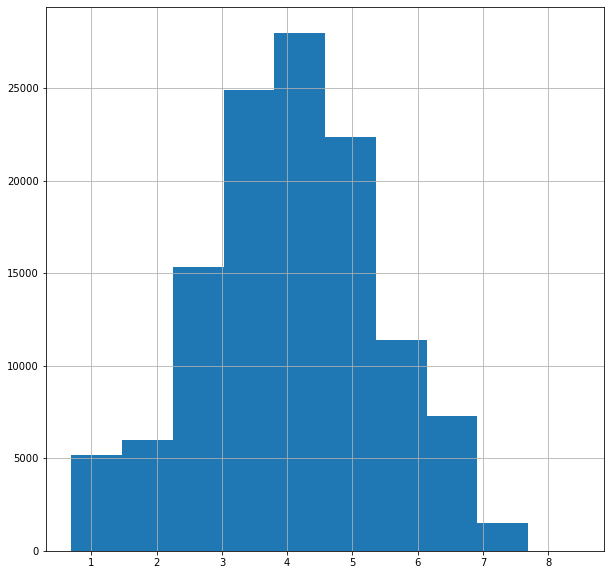

In [ ]:
data["descriptionLenLog"].hist()
plt.show()

<AxesSubplot:xlabel='descriptionLen', ylabel='price'>

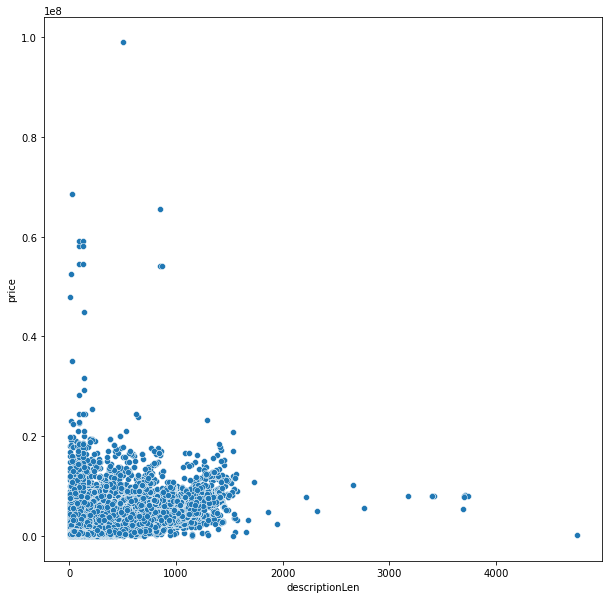

In [ ]:
sns.scatterplot(data=data, x="descriptionLen", y="price")

In [ ]:
data["descriptionScore"] = data["descriptionTrue2"].progress_apply(lambda x: Score(re.split(";|,|\s|\n|/", str(x))))
data["descriptionScoreLog"] = np.log(data["descriptionScore"] + 1)

  0%|          | 0/121950 [00:00<?, ?it/s]

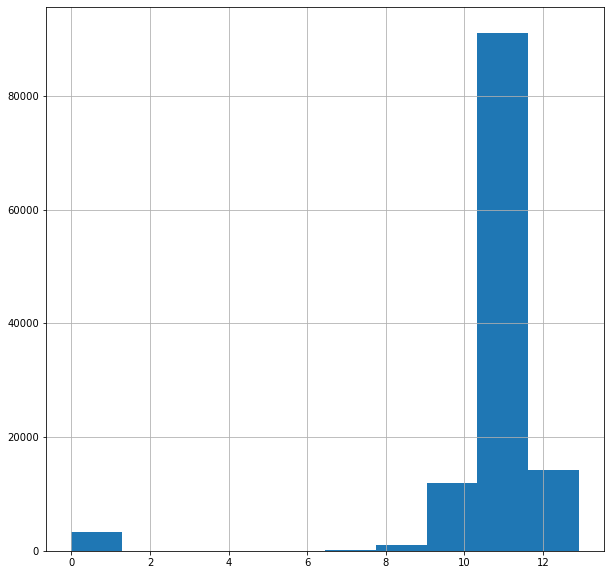

In [ ]:
np.log(data["descriptionScore"]+1).hist()
plt.show()

<AxesSubplot:xlabel='descriptionScore', ylabel='price'>

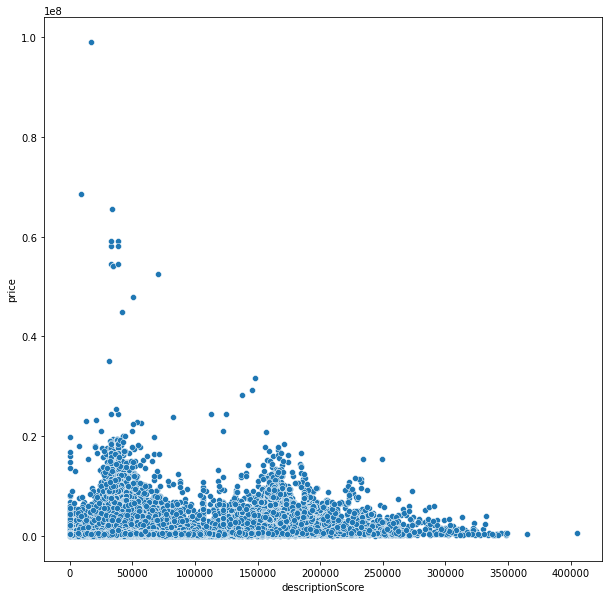

In [ ]:
sns.scatterplot(data=data, x="descriptionScore", y="price")

In [ ]:
data[:1]

bodyType brand   color fuelType  modelDate  numberOfDoors  productionDate  \
0    седан  AUDI  чёрный   бензин     30.000          4.000              29   

  vehicleTransmission  engineDisplacement  enginePower  \
0        механическая               2.800      174.000   

                                         description  mileage  Привод   Руль  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  полный  Левый   

   Владельцы       ПТС  Владение       price model_name  КомплектацияTrue  \
0      3.000  Оригинал       NaN 200,000.000        100                 0   

  country bodyTypeRough  sample  \
0  Europe         седан       1   

                                     descriptionTrue  dealer  \
0  [машина, приличн, состоять, не, гнилой, не, рж...       0   

   description_neutral  description_negative  description_skip  \
0                0.484                 0.192             0.133   

   description_positive  description_speech  \
0                 0.119               0.002   

                              description_vectorized  description_claster  \
0  [-0.64359635, 0.42609328, -1.5816237, 0.295850...                1.000   

                                    descriptionTrue2  descriptionLen  \
0  МАШИНА В ПРИЛИЧНОМ СОСТОЯНИИ НЕ ГНИЛАЯ НЕ РЖАВ...              35   

   descriptionScore  descriptionScoreLog  
0        47,944.029               10.778

In [ ]:
train = data[data["sample"]==1].drop("sample", axis=1)
test = data[data["sample"]==0].drop("sample", axis=1)

<AxesSubplot:>

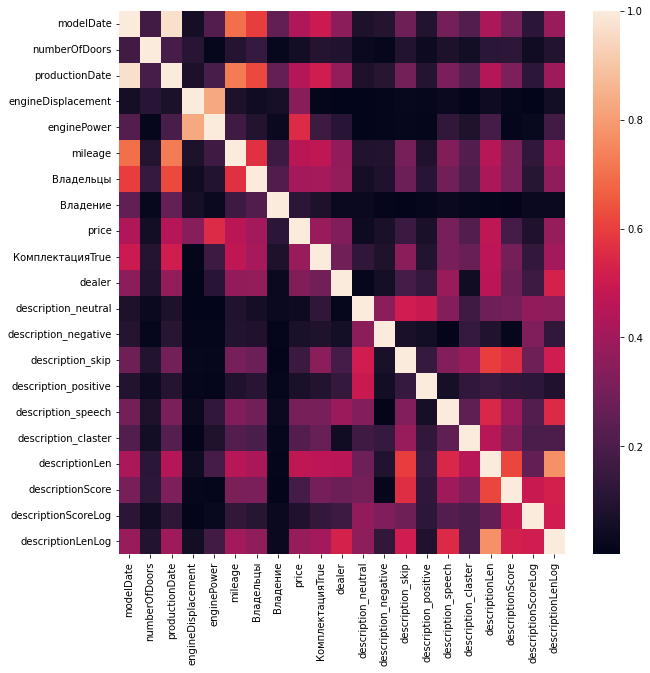

In [ ]:
sns.heatmap(np.abs(train.corr()))

In [124]:
train[:1]

bodyType brand   color fuelType  modelDate  numberOfDoors  productionDate  \
0    седан  AUDI  чёрный   бензин     30.000          4.000              29   

  vehicleTransmission  engineDisplacement  enginePower  \
0        механическая               2.800      174.000   

                                         description  mileage  Привод   Руль  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  полный  Левый   

   Владельцы       ПТС  Владение       price model_name  КомплектацияTrue  \
0      3.000  Оригинал       NaN 200,000.000        100                 0   

  country bodyTypeRough                                    descriptionTrue  \
0  Europe         седан  [машина, приличн, состоять, не, гнилой, не, рж...   

   dealer  description_neutral  description_negative  description_skip  \
0       0                0.484                 0.192             0.133   

   description_positive  description_speech  \
0                 0.119               0.002   

                              description_vectorized  description_claster  \
0  [-0.64359635, 0.42609328, -1.5816237, 0.295850...                1.000   

                                    descriptionTrue2  descriptionLen  \
0  МАШИНА В ПРИЛИЧНОМ СОСТОЯНИИ НЕ ГНИЛАЯ НЕ РЖАВ...              35   

   descriptionScore  descriptionScoreLog  
0        47,944.029               10.778

Какие колонки совпадают и оставить:

In [166]:
list_cross = set()
list_cross.update(["bodyType","brand", "enginePower", "fuelType", "mileage", "modelDate", "model_name", "numberOfDoors", "productionDate",
"vehicleTransmission", "Владельцы", "Владение", "Привод","Руль", "engineDisplacement", "color", "descriptionLen", "descriptionScore", "descriptionScoreLog"])
list_cross = list(list_cross)
list_cat = ['bodyType', 'brand', 'fuelType', 'model_name',  'vehicleTransmission', 'Привод', "color", "Руль"]
target = "price"
list_cross.sort()

In [168]:
train[list_cross][:1]

bodyType brand   color  descriptionLen  descriptionScore  \
0    седан  AUDI  чёрный              35        35,701.457   

   descriptionScoreLog  engineDisplacement  enginePower fuelType  mileage  \
0               10.483               2.800      174.000   бензин   350000   

   modelDate model_name  numberOfDoors  productionDate vehicleTransmission  \
0     30.000        100          4.000              29        механическая   

   Владельцы  Владение  Привод   Руль  
0      3.000       NaN  полный  Левый

In [169]:
test[list_cross][:1]

bodyType  brand  color  descriptionLen  descriptionScore  \
0  лифтбек  SKODA  синий             159        27,660.491   

   descriptionScoreLog  engineDisplacement  enginePower fuelType  mileage  \
0               10.228               1.200          105   бензин    74000   

   modelDate model_name  numberOfDoors  productionDate vehicleTransmission  \
0          7    OCTAVIA              5               6    роботизированная   

   Владельцы  Владение    Привод   Руль  
0          3       NaN  передний  Левый

## Data Preprocessing

In [1054]:
#train.dropna(subset=['productionDate','mileage'], inplace=True)
#train.dropna(subset=['price'], inplace=True)

In [170]:
df_train = train[list_cross]
df_test = test[list_cross]

In [171]:
y = train['price']

## Label Encoding

In [172]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет


C:\Users\Max\AppData\Local\Temp/ipykernel_10356/1662330491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # помечаем где у нас трейн
C:\Users\Max\AppData\Local\Temp/ipykernel_10356/1662330491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sample'] = 0 # помечаем где у нас тест


In [173]:
data["engineDisplacement"].fillna(1.3, inplace=True)
#data["Владение"].fillna(data["Владение"].median(), inplace=True)

In [174]:
for colum in list_cat:
    data[colum] = data[colum].astype('category').cat.codes


In [175]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [120]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [121]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 106.42%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [179]:
train_data = Pool(data = X_train,
                  label = y_train)

In [193]:
print(train_data.slice([0]).num_row())

1


In [219]:
def objective(trial):
    #train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    parameters = {'depth' : [4,6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1, 0.15,0.2],
              
              }

    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
        "depth": trial.suggest_int("depth", 8, 12, 2),
        #'iterations' : trial.suggest_int("depth", 1000), 
     #   "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    #    "bootstrap_type": trial.suggest_categorical(
     #       "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
 #       )
    }

   # if param["bootstrap_type"] == "Bayesian":
   #     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
   # elif param["bootstrap_type"] == "Bernoulli":
   #     param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**param, iterations = 2500,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          silent=True,
                          task_type = "CPU")

    gbm.fit(train_data, eval_set=(X_test, y_test), verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_test)
    return mape(y_test, preds)

In [220]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2022-04-10 12:00:03,324] A new study created in memory with name: no-name-f21d2e0b-3410-4efc-9bf0-24edc5d42d36
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-04-10 12:00:36,173] Trial 0 finished with value: 0.13908305236277627 and parameters: {'learning_rate': 0.08685863099572473, 'depth': 8}. Best is trial 0 with value: 0.13908305236277627.


KeyboardInterrupt: 

{'learning_rate': 0.19588316021130095, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [1101]:
print(study.best_params)
optuna.visualization.plot_optimization_history(study)

In [ ]:
# save your hyperparameter searches 
#joblib.dump(study, 'study.pkl')

In [122]:
                 
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          task_type = "CPU",
                          silent=True,
                          depth = 12,
                          learning_rate=0.1,
                          l2_leaf_reg=5
                           # l2_leaf_reg=3, random_strength=1 , learning_rate=0.01, one_hot_max_size=2, bagging_temperature=1
                         )
model.fit(train_data,
         eval_set = (X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

model.save_model('catboost_single_model_baseline.model')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1113]:
model = CatBoostRegressor(iterations = 2500,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['MAE'],
                          task_type = "CPU",
                          silent=True,
                          depth = 10,
                          learning_rate=0.1,
                           # l2_leaf_reg=3, random_strength=1 , learning_rate=0.01, one_hot_max_size=2, bagging_temperature=1
                         )
grid = {'learning_rate': [0.03,0.05, 0.1,0.2],
        'depth': [4, 6, 10,12],
        'l2_leaf_reg': [1, 3, 5, 7, 9,12]}

model.randomized_search(grid, train_data, plot=True, 
                  cv=5,
                  n_iter=50,
                  calc_cv_statistics=True,
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1579567586
bestIteration = 2499

0:	loss: 0.1579568	best: 0.1579568 (0)	total: 15.2s	remaining: 12m 23s

bestTest = 0.1639953615
bestIteration = 2497

1:	loss: 0.1639954	best: 0.1579568 (0)	total: 28.7s	remaining: 11m 28s

bestTest = 0.1945450174
bestIteration = 2499

2:	loss: 0.1945450	best: 0.1579568 (0)	total: 42.5s	remaining: 11m 5s

bestTest = 0.1547101738
bestIteration = 2485

3:	loss: 0.1547102	best: 0.1547102 (3)	total: 56.7s	remaining: 10m 52s

bestTest = 0.1799373523
bestIteration = 2499

4:	loss: 0.1799374	best: 0.1547102 (3)	total: 1m 9s	remaining: 10m 27s

bestTest = 0.1666041812
bestIteration = 2499

5:	loss: 0.1666042	best: 0.1547102 (3)	total: 1m 24s	remaining: 10m 22s

bestTest = 0.2013766343
bestIteration = 2498

6:	loss: 0.2013766	best: 0.1547102 (3)	total: 1m 40s	remaining: 10m 16s

bestTest = 0.1740253975
bestIteration = 2492

7:	loss: 0.1740254	best: 0.1547102 (3)	total: 1m 54s	remaining: 10m 2s

bestTest = 0.1616268972
bestIteration = 2490

8:	loss:

{'params': {'depth': 12, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [1114]:
model.get_params()

{'iterations': 2500,
 'learning_rate': 0.1,
 'depth': 12,
 'loss_function': 'RMSE',
 'random_seed': 42,
 'silent': True,
 'custom_metric': ['MAE'],
 'eval_metric': 'MAPE',
 'task_type': 'CPU',
 'l2_leaf_reg': 5}

In [123]:
model.plot_tree(tree_idx=0)

Проверим решение CatBoost

In [124]:
res = pd.DataFrame(train_data.get_features())
res["y"] = (model.predict(train_data.get_features())-train_data.get_label())/train_data.get_label()
res["y_true"] = train_data.get_label().astype(int)
res["y_our"] = list(map(int, model.predict(train_data.get_features())))
res[res["y"]>2].sort_values("y", ascending=False)

0      1      2      3          4     5       6     7           8  \
1861  15.000 29.000  7.000 84.000 36,119.367 1.300  68.000 0.000 300,000.000   
61714 12.000  9.000 11.000 47.000 34,783.574 2.000 130.000 0.000 148,000.000   
61974 18.000  9.000 11.000 42.000 34,019.645 1.600  90.000 0.000 140,000.000   
25129 12.000 21.000 12.000 39.000 40,786.848 1.300 193.000 0.000 350,000.000   
44645 12.000  0.000 12.000 39.000 41,321.793 1.800  90.000 0.000 250,000.000   
34564 15.000 33.000  4.000 34.000 32,521.471 1.600 115.000 0.000 300,000.000   

           9      10    11     12    13    14        15    16    17     y  \
1861  26.000 402.000 5.000 23.000 2.000 3.000       NaN 1.000 0.000 2.486   
61714 19.000 411.000 4.000 17.000 0.000 3.000       NaN 1.000 0.000 2.148   
61974 25.000 374.000 5.000 23.000 2.000 3.000       NaN 1.000 0.000 2.130   
25129 28.000 393.000 4.000 27.000 0.000 3.000 2,273.000 0.000 0.000 2.127   
44645 34.000  70.000 4.000 30.000 2.000 3.000   539.000 1.000 0.000 2.126   
34564 32.000 900.000 5.000 26.000 0.000 3.000       NaN 2.000 1.000 2.096   

       y_true   y_our  
1861    20000   69714  
61714   50000  157410  
61974   25000   78243  
25129   55000  171967  
44645   30000   93787  
34564   30000   92886

Значимость признаков.

In [126]:
a = dict(zip(train_data.get_feature_names(), model.get_feature_importance(train_data)))
pd.DataFrame(a.items()).sort_values(1, ascending=False)

0      1
6           enginePower 24.827
10           model_name 12.827
8               mileage 12.578
12       productionDate  9.371
9             modelDate  9.166
1                 brand  6.278
7              fuelType  5.640
16               Привод  4.847
5    engineDisplacement  4.421
0              bodyType  3.488
3        descriptionLen  1.565
4      descriptionScore  1.089
14            Владельцы  0.911
13  vehicleTransmission  0.852
11        numberOfDoors  0.802
15             Владение  0.737
2                 color  0.598
17                 Руль  0.004

In [713]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.70%


### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [ ]:
np.log(y_train)

10627   14.221
25660   13.895
38088   13.732
73765   13.152
68953   14.693
         ...  
6597    13.218
56469   12.301
78978   12.737
890     12.567
16372   12.429
Name: price, Length: 69483, dtype: float64

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [ ]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.55%


Как видим точность возросла до 12.5%, а что будет на ЛБ?

# Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026   601,521.234
1  1100549428   825,581.645
2  1100658222   866,058.331
3  1100937408   692,906.645
4  1101037972   708,764.409
5  1100912634   693,038.786
6  1101228730   639,127.146
7  1100165896   401,768.043
8  1100768262 1,629,606.407
9  1101218501   840,292.420

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing